# Debug the Calculation of Stroke Error

In [1]:
import os
import xmltodict

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image, ImageDraw
from random import randint, seed
from xmlparse import xmlToGeometry

import numpy as np

In [2]:
def loadRef(han_char, ref_dir = "Reference"):
    stroke_list = []
    frac_dists = []
    ref_path = f"{ref_dir}/{han_char[0]}000/{han_char}.han"
    ref_xml = open(ref_path, "r").read()
    root = xmltodict.parse(ref_xml)
    bounds = root["hanDefinition"]["bounds"]
    x_min, y_min, x_max, y_max = (float(bounds["@left"]), float(bounds["@bottom"]), float(bounds["@right"]), float(bounds["@top"]))
    scale = (int(x_max-x_min), int(y_max-y_min))
    strokes = root["hanDefinition"]["strokes"]["stroke"]
    for stroke in strokes:
        points = stroke["points"]["forward"]
        point_arr = []
        frac_arr = []
        for point in points["pointDistance"]:
            point_arr.append((float(point["@x"])-x_min,
                              float(point["@y"])-y_min))
            frac_arr.append(float(point["@fractionalDistance"]))
        stroke_list.append(np.array(point_arr))
        frac_dists.append(np.array(frac_arr))
    return stroke_list, frac_dists, scale

def loadGeometry(data_dir, han_char, output_size = (32, 32), f_read = None):
    """
    Loads geometric data about a gene characetr directly from the XML source
    """
    if f_read is None:
        dir_list = os.listdir(f"{data_dir}/{han_char}")
        dir_list.sort()
    else:
        dir_list = f_read
    g_data = []
    f_names = []
    for f in dir_list:
        flines = open(f"{data_dir}/{han_char}/{f}", "rb").readlines()
        f_names.append(flines[0].decode()[:-1])
    for f in f_names:
        g = xmlToGeometry(f, output_size)
        g_data.append(g)
    return g_data


In [3]:
ref_g, ref_l, output_size = loadRef("5EA6", "Reference")
# in order to test multiple samples, add the file numbers to the f_read list and delete the [0] at the line end
# be aware this will turn g and l into iterables, so handle your loops accordingly
g, l = loadGeometry("HanBitmap", "5EA6", output_size, f_read = ["345"])[0]

In [4]:
def alignStrokes(strokes, ref, p_strokes, p_ref):
    # function to get stroke length given a stroke value (in this case, a stroke value is a 2d list
    # that contains an x coord in stroke[][0] and a y coord in stroke[][1])
    def getStrokeLen(stroke):
        length = 0 # adding all the lengths we get between two points to this variable
        # while it looks a little complicated, this is just the pythagorean theorem applied between two coordinates, just 
        # how one would calculate it on a graph: sqrt(a^2 + b^2)
        for i in range(len(stroke)-1):
            length += ((stroke[i][0] - stroke[i+1][0])**2 + (stroke[i][1] - stroke[i+1][1])**2)**0.5
        return length

    #get the lengths of each stroke for the order in the greedy algorithm
    ref_lengths = []
    for i in range(len(strokes)):
        ref_lengths.append(getStrokeLen(ref[i]))
    priority = np.argsort(ref_lengths)[::-1]
    
    strokes = np.array(strokes)
    p_strokes = np.array(p_strokes)
    ref = np.array(ref)
    p_ref = np.array(p_ref)
    
    error_maps = strokeErrorMatrix(strokes, ref, p_strokes, p_ref)
    
    print(error_maps.astype(int))

    # -1 just means unmatched here since 0 (the other 'default' filler) is a meaningful number in this context
    stroke_map = np.full(len(strokes), -1)

    
    for i in priority:
        largestref = i # this is the index for the reference stroke that is largest
        smallerror = np.argmin(error_maps[largestref, :]) # access the error map from the largest stroke's index and see which error is smallest
        print(f"{error_maps.astype(int)[i]} - minimizing for priority stroke {i}")
        error_maps[:, smallerror] = 10000
        print("Resulting error map:")
        print(error_maps.astype(int))
        stroke_map[smallerror] = largestref # set the index in the stroke_map to the reference stroke we designated
        print(stroke_map)
    
    return stroke_map

xcolors = ["#7e1e9c", "#15b01a", "#0343df", "#653700", "#e50000", "#f97306", "#033500", "#ffff14", "#001146"]
color_selection = [(int(c[1:3], 16), int(c[3:5], 16), int(c[5:7], 16)) for c in xcolors]
colors = color_selection[:len(ref_l)+1]

def strokeErrorMatrix(strokes, ref, p_strokes, p_ref):
    error_map = np.zeros((len(ref), len(strokes)), dtype=float)
    for i, ref_stroke, r_progresses in zip(range(len(ref)), ref, p_ref):
        for j, candidate_stroke, c_progresses in zip(range(len(strokes)), strokes, p_strokes):
            error_map[i, j] = strokeError(ref_stroke, candidate_stroke, r_progresses, c_progresses)
            print(f"Ref stroke {i} vs Candidate Stroke {j} - error: {error_map[i, j]}")
            img = Image.new(mode="RGBA", size=output_size)
            draw = ImageDraw.Draw(img)
            for a in range(len(ref_stroke)-1):
                x1, y1 = ref_stroke[a]
                x2, y2 = ref_stroke[a+1]
                y1 = -(y1-output_size[1]/2)+output_size[1]/2
                y2 = -(y2-output_size[1]/2)+output_size[1]/2
                draw.line(((x1, y1), (x2, y2)), width=6, fill=colors[0])
            for b in range(len(candidate_stroke)-1):
                x1, y1 = candidate_stroke[b]
                x2, y2 = candidate_stroke[b+1]
                y1 = -(y1-output_size[1]/2)+output_size[1]/2
                y2 = -(y2-output_size[1]/2)+output_size[1]/2
                draw.line(((x1, y1), (x2, y2)), width=6, fill=colors[1])
            display(img)
    return error_map

def strokeError(stroke, ref_stroke, p_stroke, p_ref, mode="max"):
    forward_stroke_error, back_stroke_error = np.zeros(len(ref_stroke)), np.zeros(len(ref_stroke))
    forward_ref_error, back_ref_error = np.zeros(len(stroke)), np.zeros(len(stroke))
    for i, rpoint, rprogress in zip(range(len(ref_stroke)), ref_stroke, p_ref):
        forward_stroke_error[i] = (np.linalg.norm(abs(rpoint-strokeTrace(stroke, p_stroke, rprogress))))
        #print(i, rpoint, strokeTrace(stroke, p_stroke, rprogress), forward_stroke_error[i])
    #print(f"Final forward stroke error: {forward_stroke_error.max()}")
    for i, rpoint, rprogress in zip(range(len(ref_stroke)), ref_stroke[::-1], p_ref[::-1]):
        back_stroke_error[i] = (np.linalg.norm(abs(rpoint-strokeTrace(stroke, p_stroke, 1-rprogress))))
        #print(i, rpoint, strokeTrace(stroke, p_stroke, 1-rprogress), back_stroke_error[i])
    #print(f"Final back stroke error: {back_stroke_error.max()}")
    for i, point, progress in zip(range(len(stroke)), stroke, p_stroke):
        forward_ref_error[i] = (np.linalg.norm((point-strokeTrace(ref_stroke, p_ref, progress))))
        #print(i, point, strokeTrace(stroke, p_stroke, progress), forward_ref_error[i])
    #print(f"Final forward ref error: {forward_ref_error.max()}")
    for i, point, progress in zip(range(len(stroke)), stroke[::-1], p_stroke[::-1]):
        back_ref_error[i] = (np.linalg.norm((point-strokeTrace(ref_stroke, p_ref, 1-progress))))
        #print(i, point, strokeTrace(stroke, p_stroke, 1-progress), back_ref_error[i])
    #print(f"Final back ref error: {back_ref_error.max()}")
    fse_maxdev = forward_stroke_error.argmax()
    bse_maxdev = back_stroke_error.argmax()
    fre_maxdev = forward_ref_error.argmax()
    bre_maxdev = back_ref_error.argmax()
    final_error = max(min(forward_stroke_error.max(), back_stroke_error.max()), min(forward_ref_error.max(), back_ref_error.max()))
    #print(f"Final error: {final_error}")
    return final_error

def strokeTrace(stroke, stroke_progresses, progress):
    if progress == 1:
        return stroke[-1]
    progress_line = len(stroke_progresses)-1
    for i in range(1, len(stroke_progresses)):
        if stroke_progresses[i] > progress:
            progress_line = i-1
            break
    startp, endp = stroke_progresses[progress_line], stroke_progresses[progress_line+1]
    norm_progress = (progress-startp)/endp
    if stroke[progress_line+1][0] == stroke[progress_line][0]:
        x = stroke[progress_line][0]
        y = norm_progress*(stroke[progress_line+1][1]-stroke[progress_line][1])+stroke[progress_line][1]
    else:
        slope = (stroke[progress_line+1][1]-stroke[progress_line][1])/(stroke[progress_line+1][0]-stroke[progress_line][0])
        intercept = stroke[progress_line][1]-slope*stroke[progress_line][0]
        x = norm_progress*(stroke[progress_line+1][0]-stroke[progress_line][0])+stroke[progress_line][0]
        y = slope*x + intercept
    return np.array((x, y))


Ref stroke 0 vs Candidate Stroke 0 - error: 182.78021064908174


/tmp/ipykernel_94450/2631318836.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  strokes = np.array(strokes)
/tmp/ipykernel_94450/2631318836.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p_strokes = np.array(p_strokes)
/tmp/ipykernel_94450/2631318836.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ref = np.array(ref)

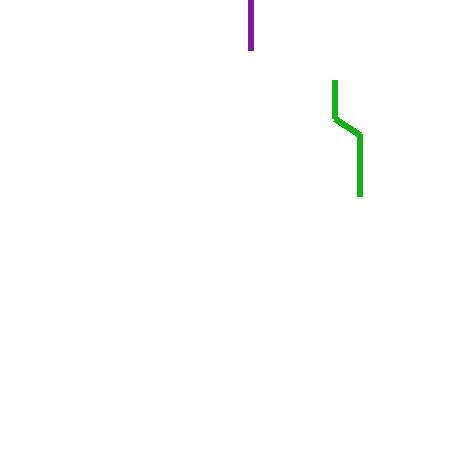

Ref stroke 0 vs Candidate Stroke 1 - error: 211.42993020061894


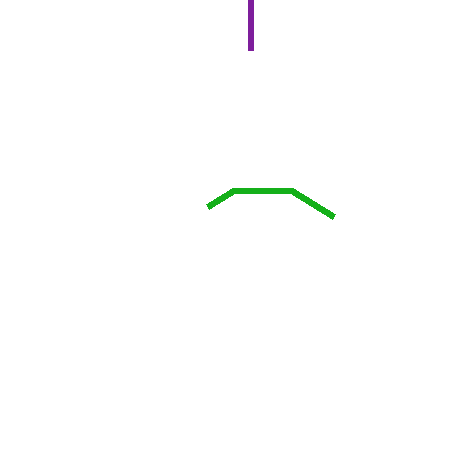

Ref stroke 0 vs Candidate Stroke 2 - error: 173.3572706978403


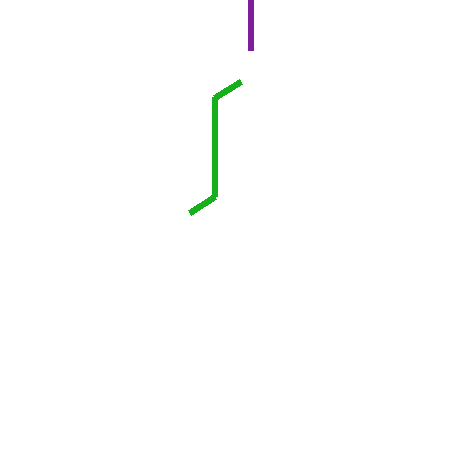

Ref stroke 0 vs Candidate Stroke 3 - error: 168.68071152224485


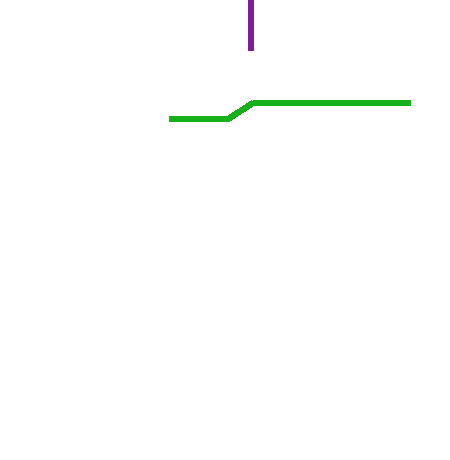

Ref stroke 0 vs Candidate Stroke 4 - error: 36.74670695024312


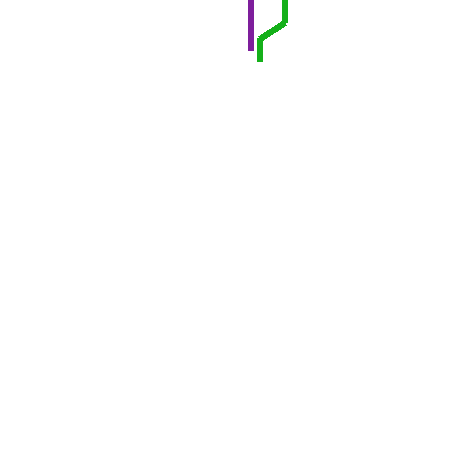

Ref stroke 0 vs Candidate Stroke 5 - error: 138.0941818017103


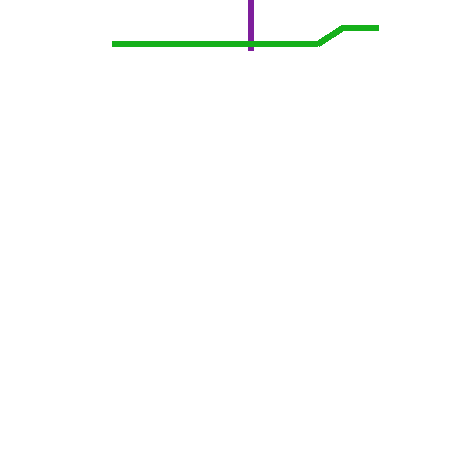

Ref stroke 0 vs Candidate Stroke 6 - error: 442.87761475161545


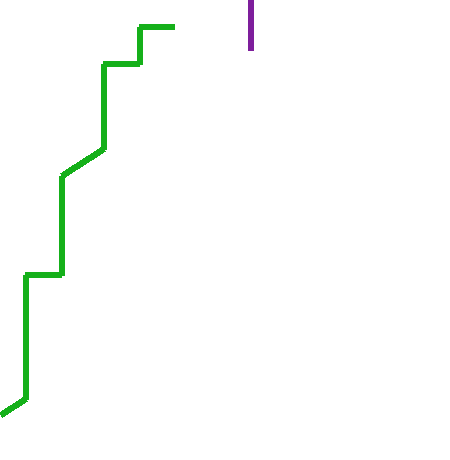

Ref stroke 0 vs Candidate Stroke 7 - error: 407.6956519000082


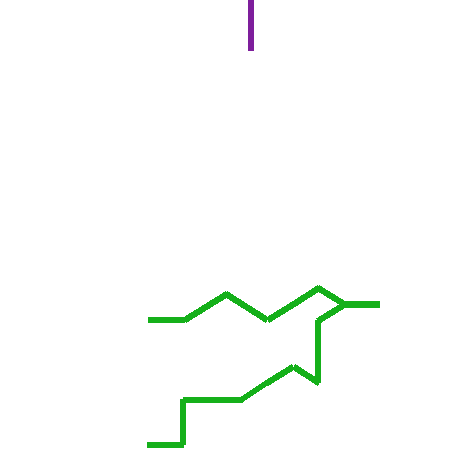

Ref stroke 0 vs Candidate Stroke 8 - error: 456.17978911828175


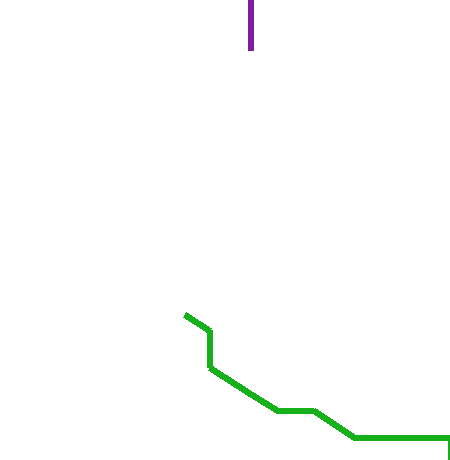

Ref stroke 1 vs Candidate Stroke 0 - error: 285.9629616941205


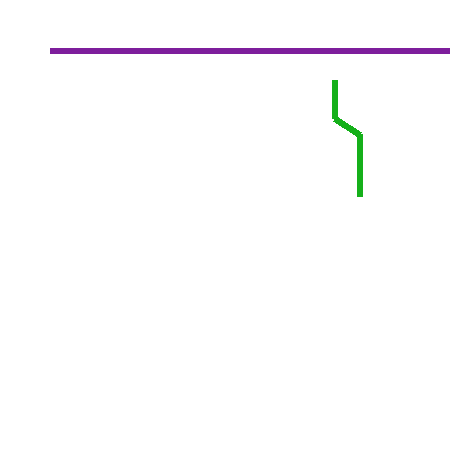

Ref stroke 1 vs Candidate Stroke 1 - error: 222.83531054546293


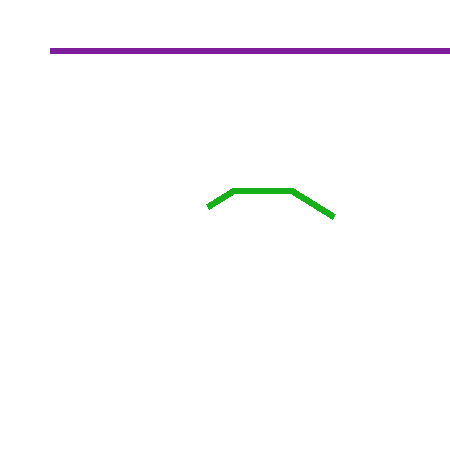

Ref stroke 1 vs Candidate Stroke 2 - error: 215.15911503329286


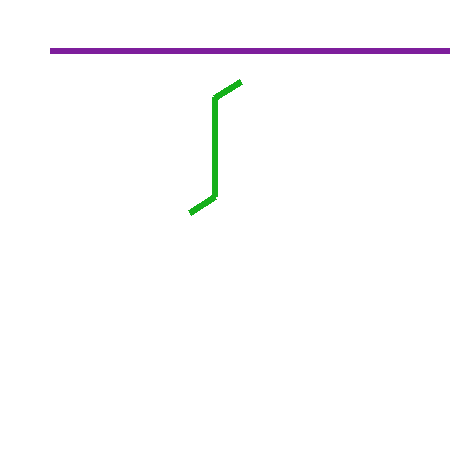

Ref stroke 1 vs Candidate Stroke 3 - error: 137.27695722396504


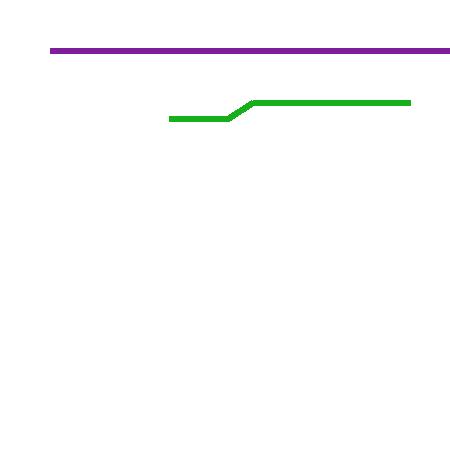

Ref stroke 1 vs Candidate Stroke 4 - error: 210.87175166046723


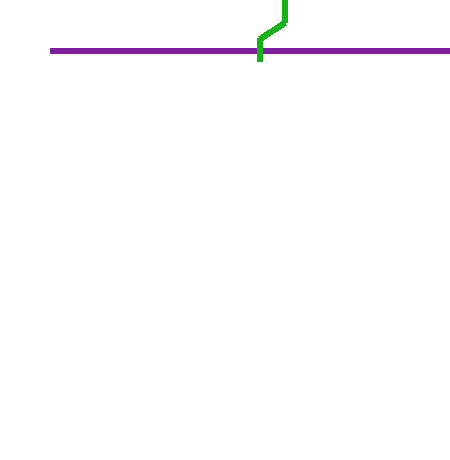

Ref stroke 1 vs Candidate Stroke 5 - error: 74.74044240417625


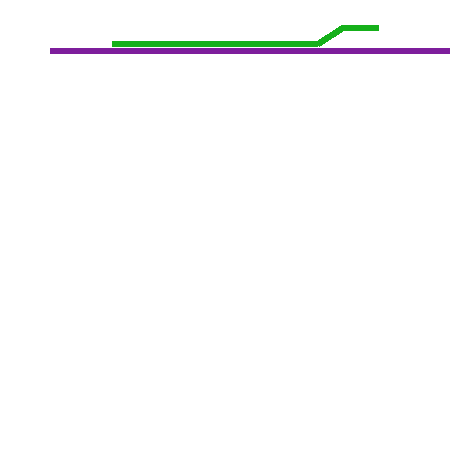

Ref stroke 1 vs Candidate Stroke 6 - error: 368.97233181917625


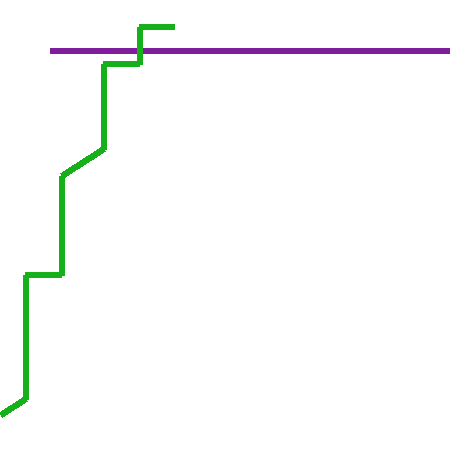

Ref stroke 1 vs Candidate Stroke 7 - error: 409.6801221800993


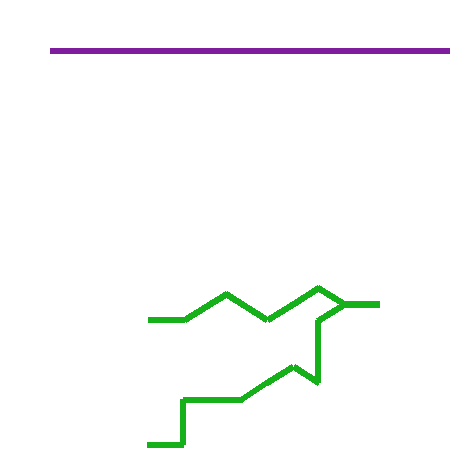

Ref stroke 1 vs Candidate Stroke 8 - error: 410.0


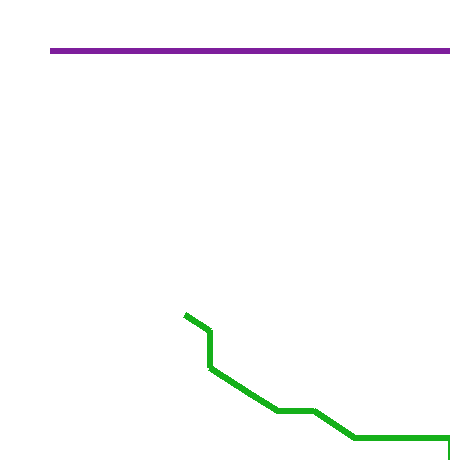

Ref stroke 2 vs Candidate Stroke 0 - error: 448.18097286239794


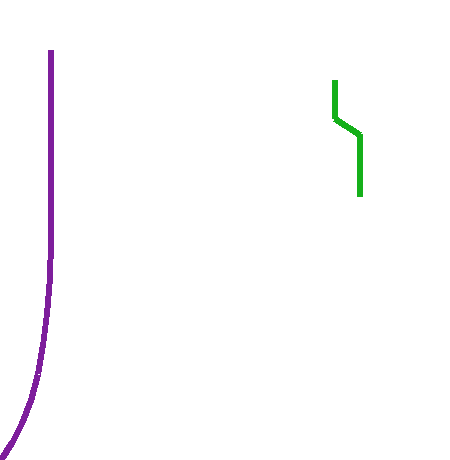

Ref stroke 2 vs Candidate Stroke 1 - error: 330.8131075191826


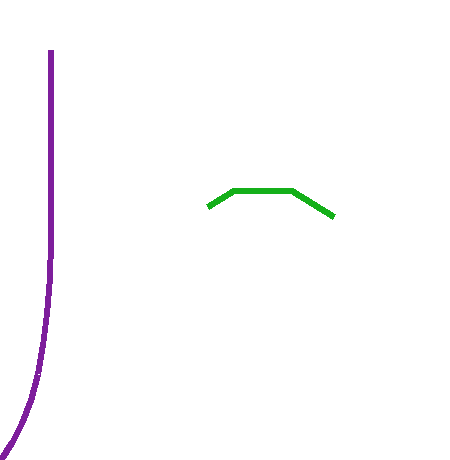

Ref stroke 2 vs Candidate Stroke 2 - error: 312.098332063239


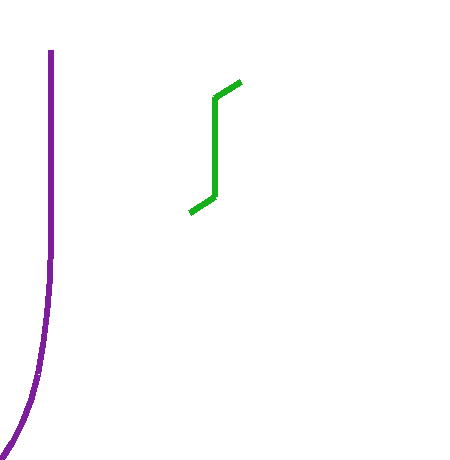

Ref stroke 2 vs Candidate Stroke 3 - error: 381.437999705123


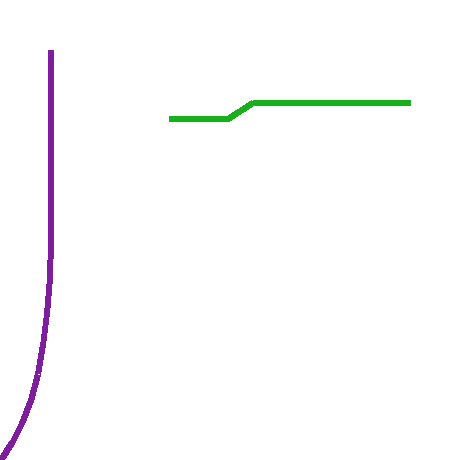

Ref stroke 2 vs Candidate Stroke 4 - error: 475.9525672613428


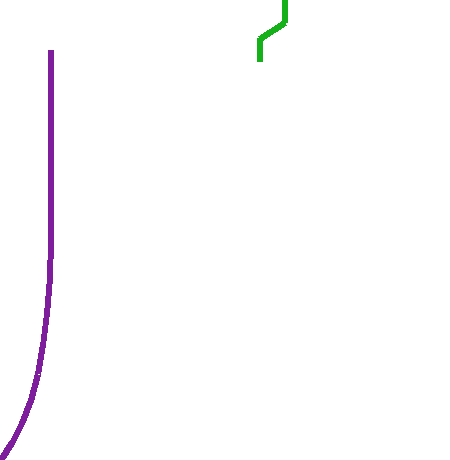

Ref stroke 2 vs Candidate Stroke 5 - error: 430.55880166815393


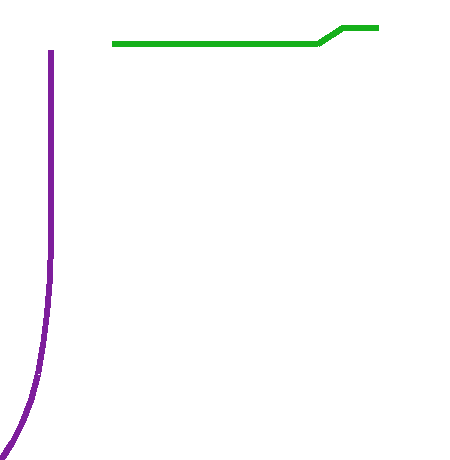

Ref stroke 2 vs Candidate Stroke 6 - error: 126.96508256529052


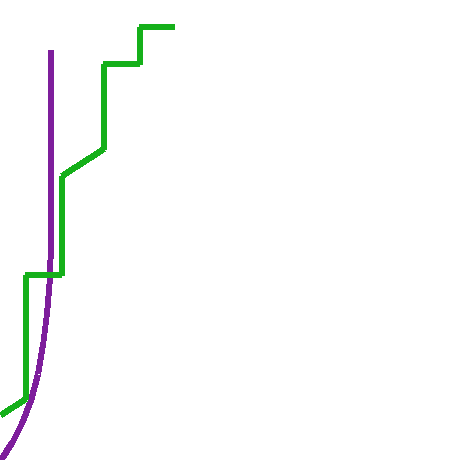

Ref stroke 2 vs Candidate Stroke 7 - error: 339.064966344075


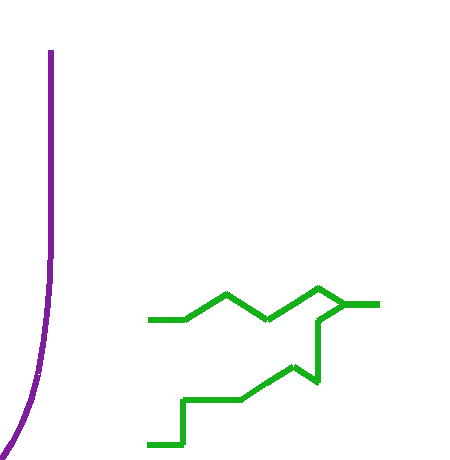

Ref stroke 2 vs Candidate Stroke 8 - error: 450.0


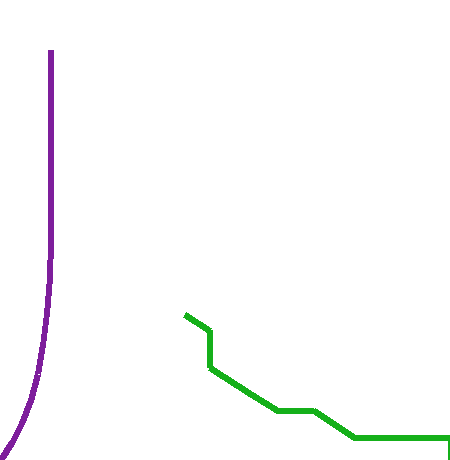

Ref stroke 3 vs Candidate Stroke 0 - error: 251.45302072237556


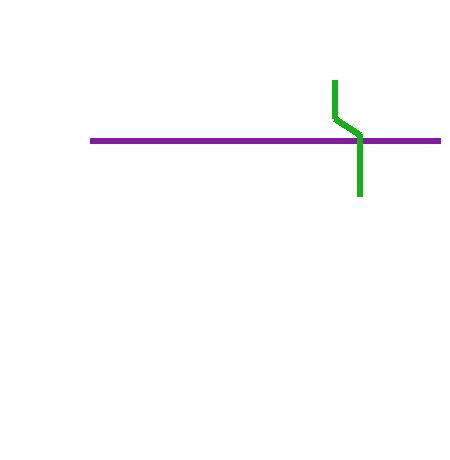

Ref stroke 3 vs Candidate Stroke 1 - error: 135.73661310503724


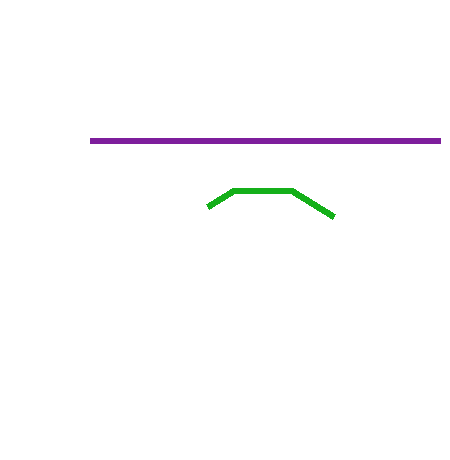

Ref stroke 3 vs Candidate Stroke 2 - error: 207.1881337491938


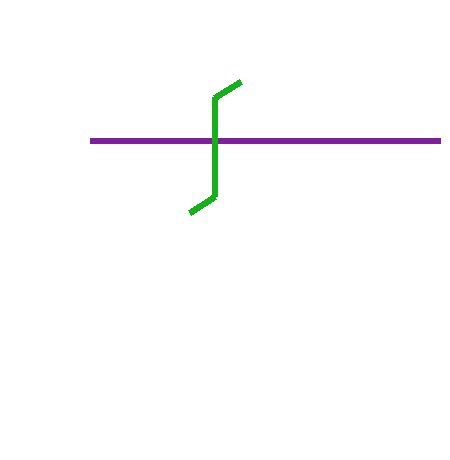

Ref stroke 3 vs Candidate Stroke 3 - error: 82.14127325561861


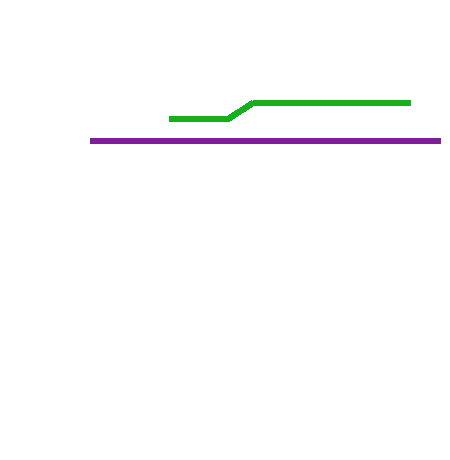

Ref stroke 3 vs Candidate Stroke 4 - error: 208.1802213350508


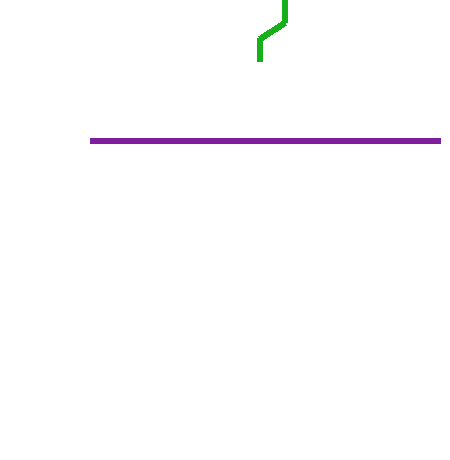

Ref stroke 3 vs Candidate Stroke 5 - error: 127.62728249769094


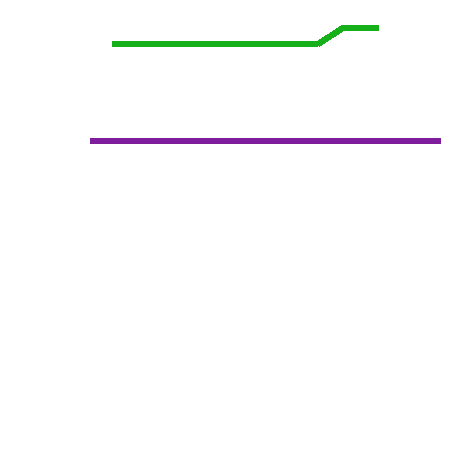

Ref stroke 3 vs Candidate Stroke 6 - error: 299.51107850146224


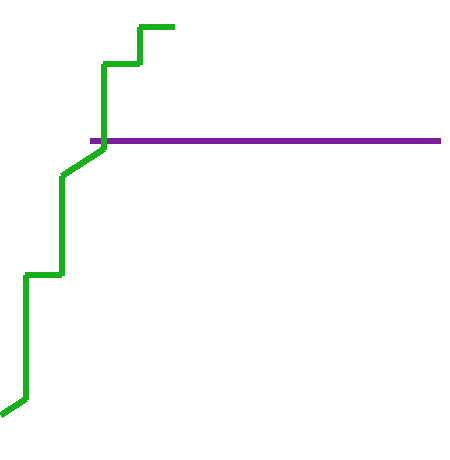

Ref stroke 3 vs Candidate Stroke 7 - error: 343.2475620612074


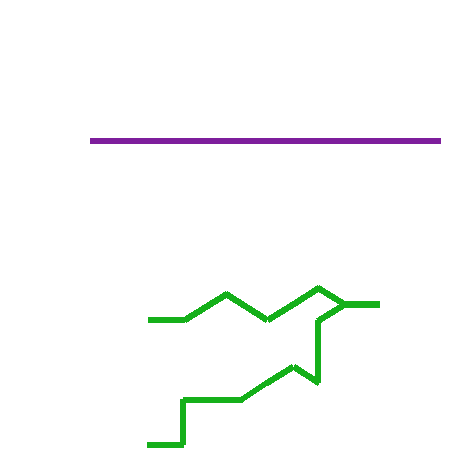

Ref stroke 3 vs Candidate Stroke 8 - error: 320.1562118716424


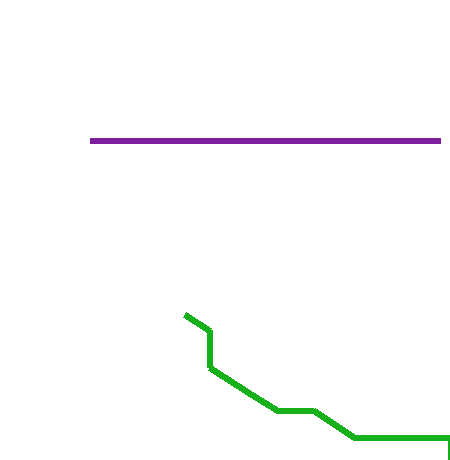

Ref stroke 4 vs Candidate Stroke 0 - error: 181.9321096119079


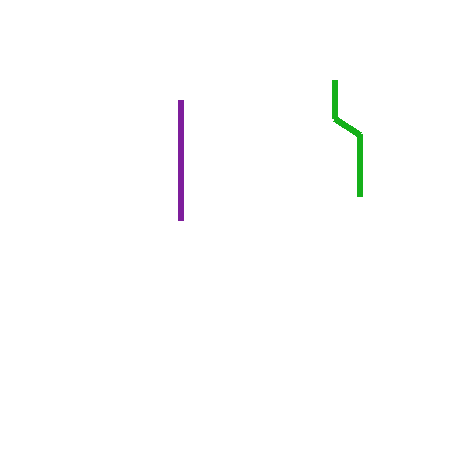

Ref stroke 4 vs Candidate Stroke 1 - error: 154.3435261483688


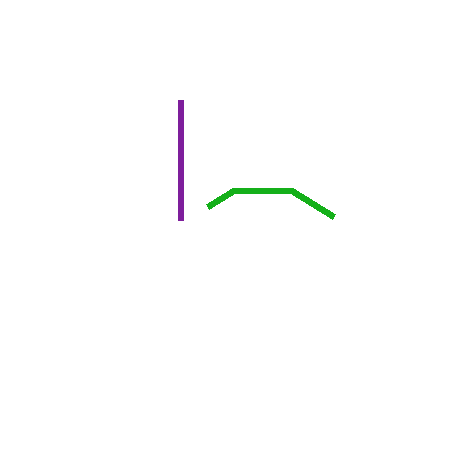

Ref stroke 4 vs Candidate Stroke 2 - error: 64.20084091069798


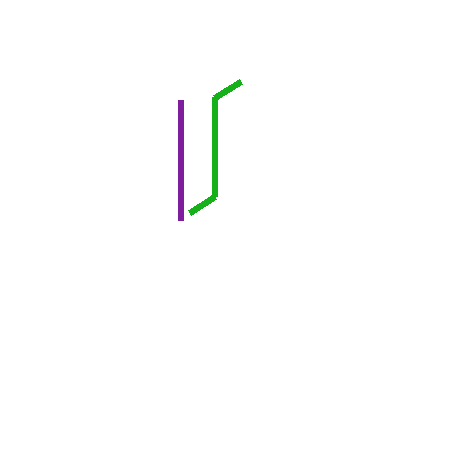

Ref stroke 4 vs Candidate Stroke 3 - error: 230.46912582786433


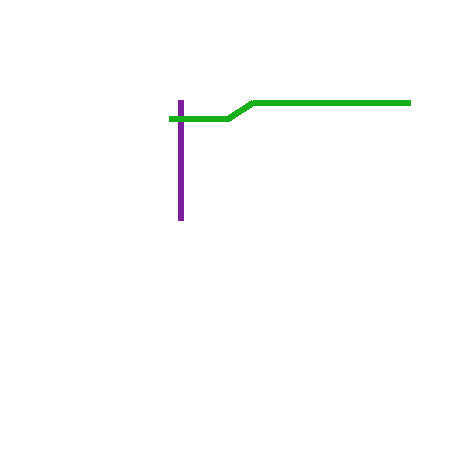

Ref stroke 4 vs Candidate Stroke 4 - error: 177.6175143001057


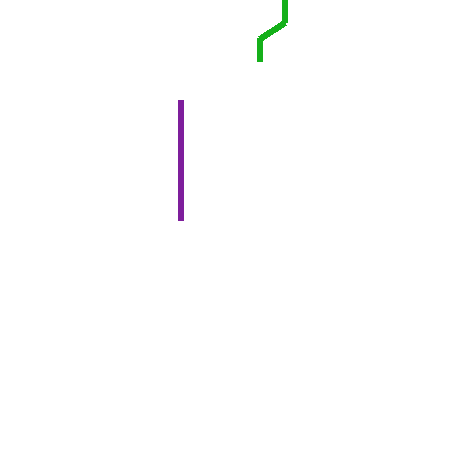

Ref stroke 4 vs Candidate Stroke 5 - error: 211.12368323088037


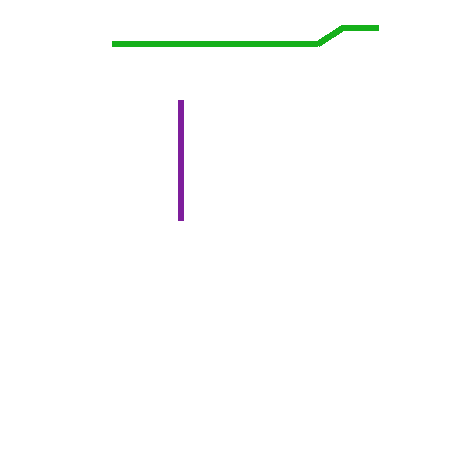

Ref stroke 4 vs Candidate Stroke 6 - error: 265.795360726618


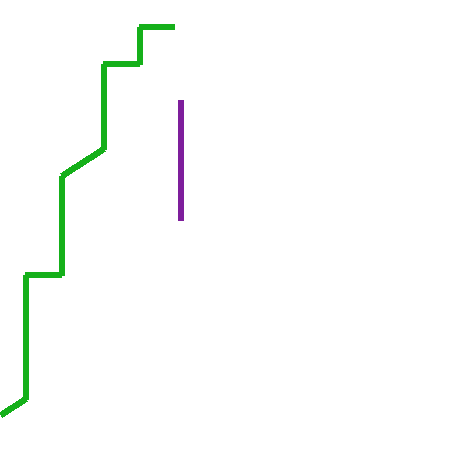

Ref stroke 4 vs Candidate Stroke 7 - error: 252.52085139390178


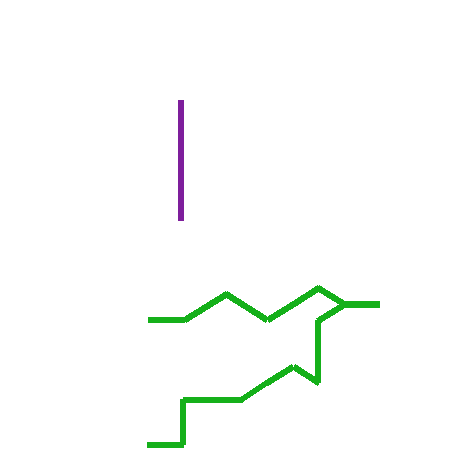

Ref stroke 4 vs Candidate Stroke 8 - error: 361.24783736376884


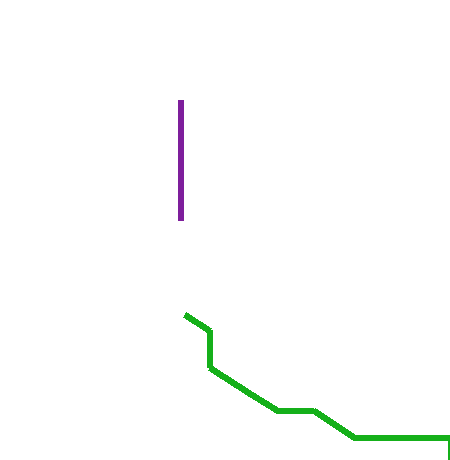

Ref stroke 5 vs Candidate Stroke 0 - error: 34.55480613509439


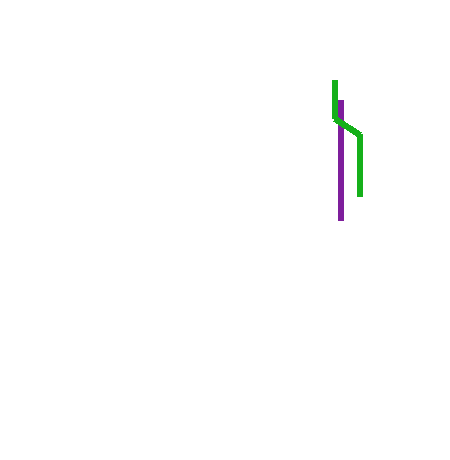

Ref stroke 5 vs Candidate Stroke 1 - error: 132.68547898344656


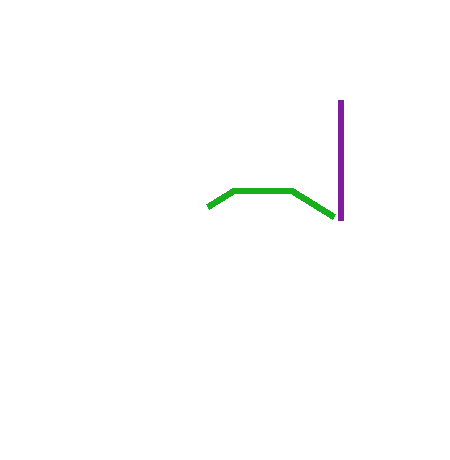

Ref stroke 5 vs Candidate Stroke 2 - error: 149.56858786504276


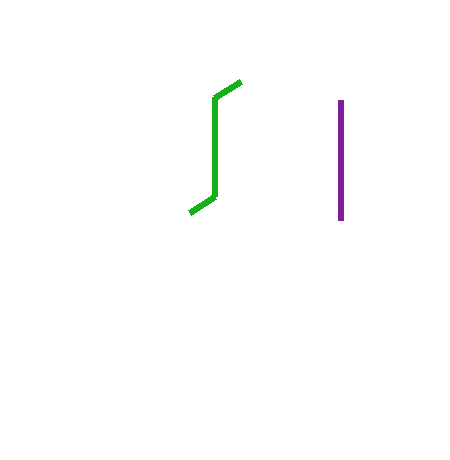

Ref stroke 5 vs Candidate Stroke 3 - error: 171.78284211734476


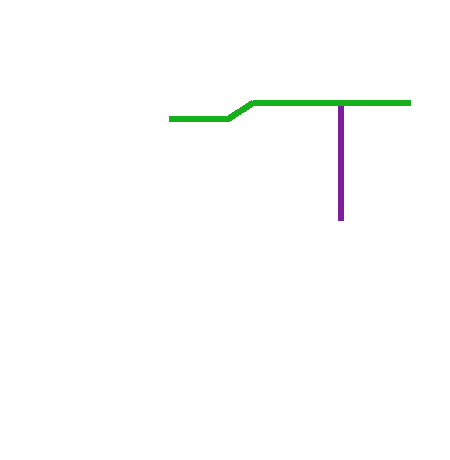

Ref stroke 5 vs Candidate Stroke 4 - error: 177.12395860565297


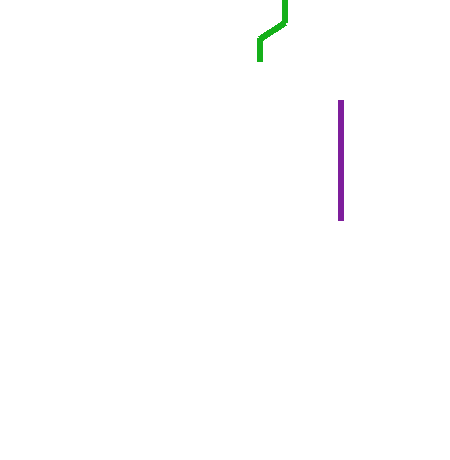

Ref stroke 5 vs Candidate Stroke 5 - error: 234.68817162249528


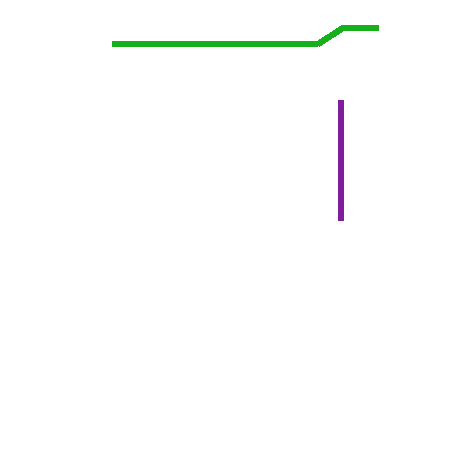

Ref stroke 5 vs Candidate Stroke 6 - error: 392.23357044469435


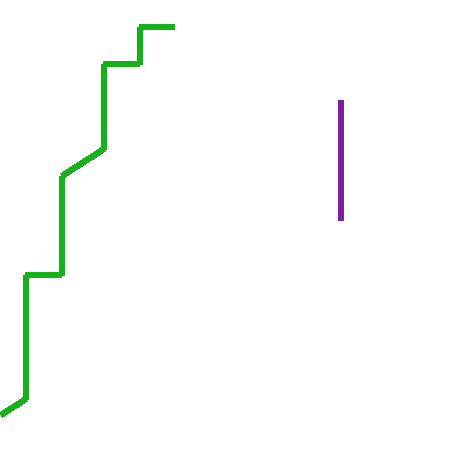

Ref stroke 5 vs Candidate Stroke 7 - error: 295.8302678202371


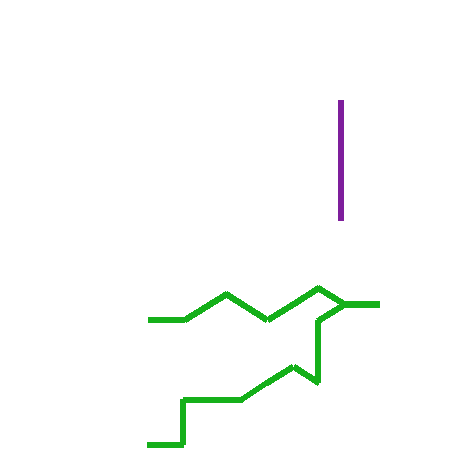

Ref stroke 5 vs Candidate Stroke 8 - error: 277.18651832285434


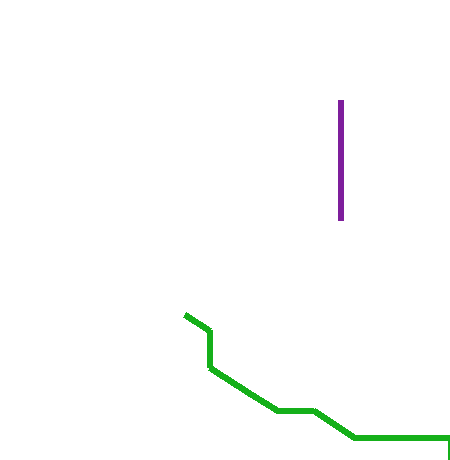

Ref stroke 6 vs Candidate Stroke 0 - error: 181.27346994215608


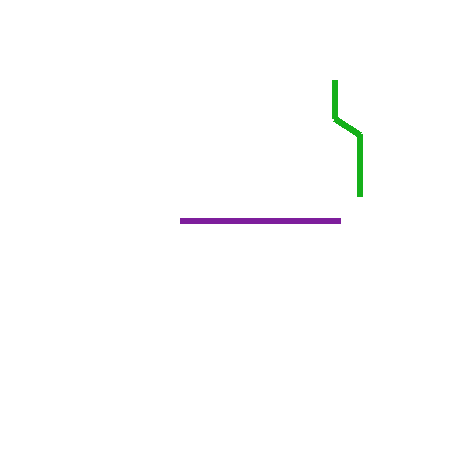

Ref stroke 6 vs Candidate Stroke 1 - error: 34.40958259835721


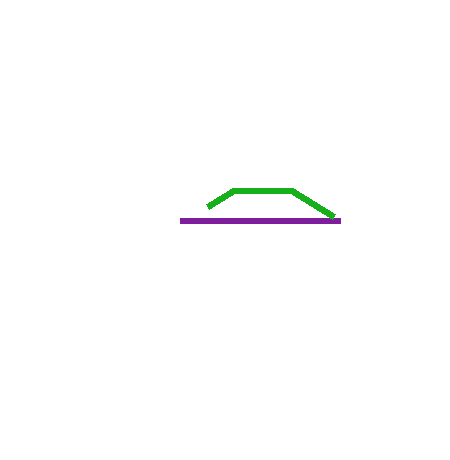

Ref stroke 6 vs Candidate Stroke 2 - error: 151.84187786216862


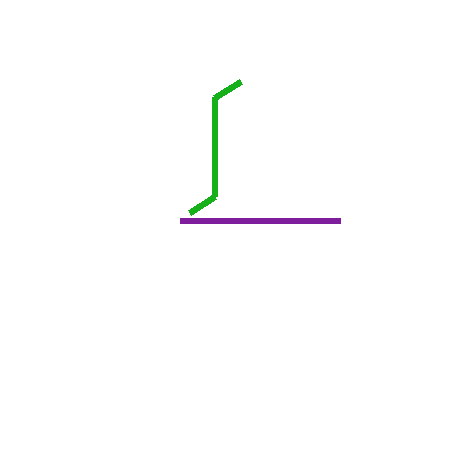

Ref stroke 6 vs Candidate Stroke 3 - error: 137.42220124053895


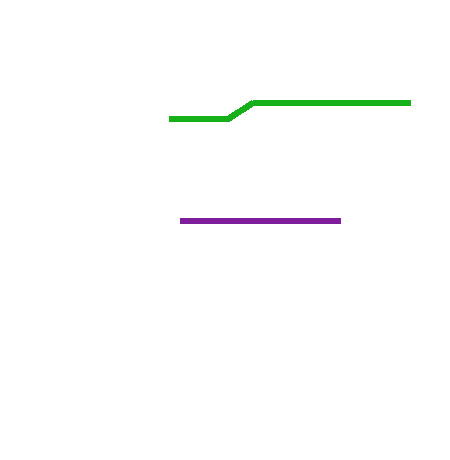

Ref stroke 6 vs Candidate Stroke 4 - error: 226.5481629875461


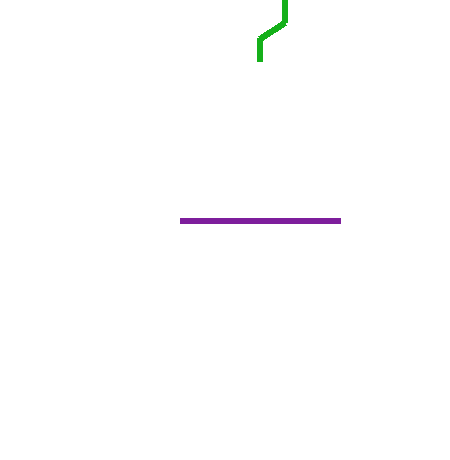

Ref stroke 6 vs Candidate Stroke 5 - error: 195.6747237849303


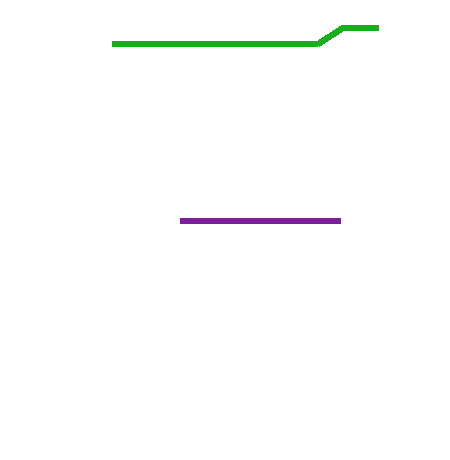

Ref stroke 6 vs Candidate Stroke 6 - error: 270.889305093987


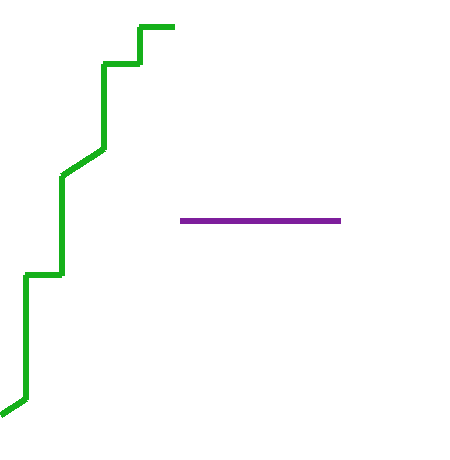

Ref stroke 6 vs Candidate Stroke 7 - error: 226.93372487425378


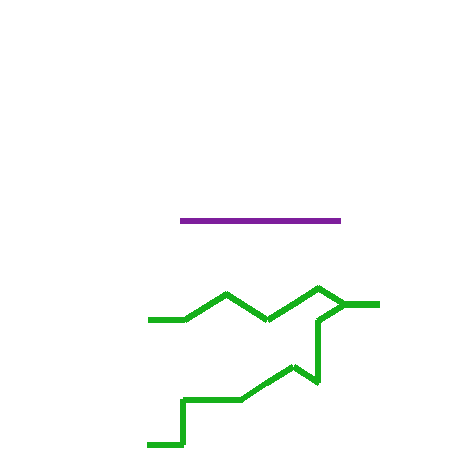

Ref stroke 6 vs Candidate Stroke 8 - error: 264.0075756488817


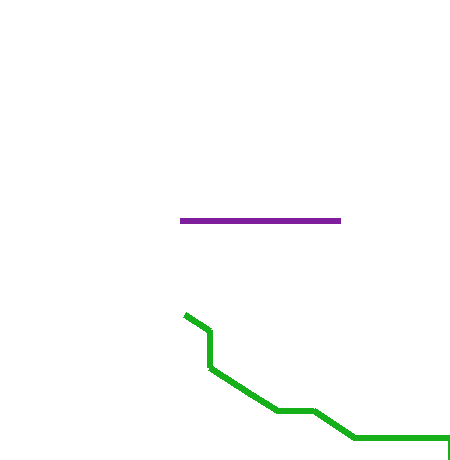

Ref stroke 7 vs Candidate Stroke 0 - error: 377.6904754705211


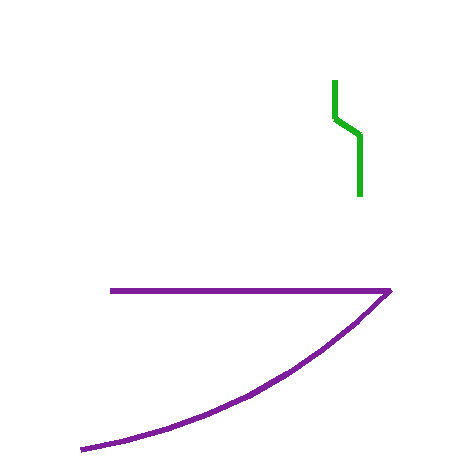

Ref stroke 7 vs Candidate Stroke 1 - error: 274.44009942064173


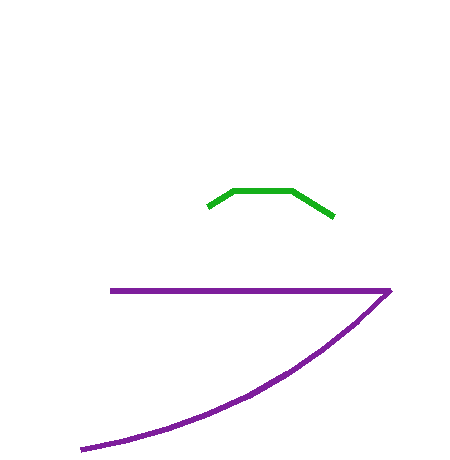

Ref stroke 7 vs Candidate Stroke 2 - error: 261.6607779296502


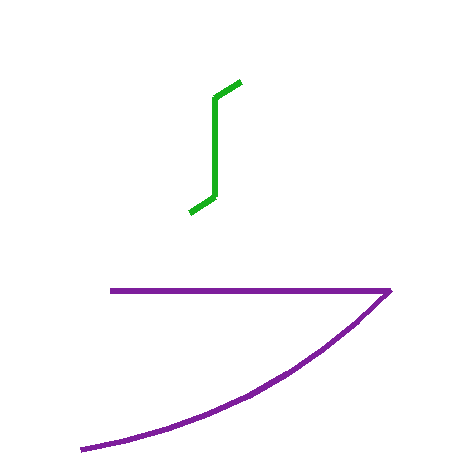

Ref stroke 7 vs Candidate Stroke 3 - error: 354.4211510902607


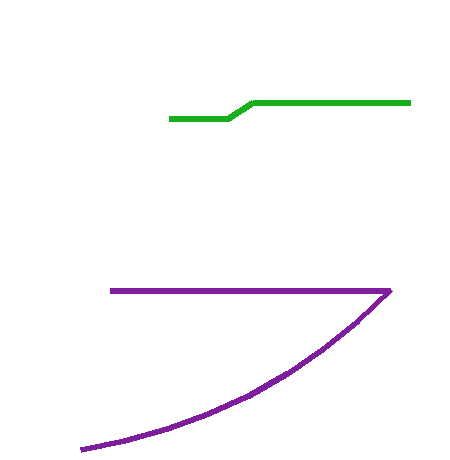

Ref stroke 7 vs Candidate Stroke 4 - error: 428.2256706485459


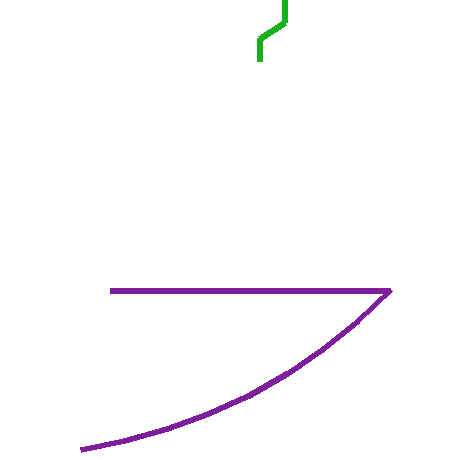

Ref stroke 7 vs Candidate Stroke 5 - error: 406.9917997047234


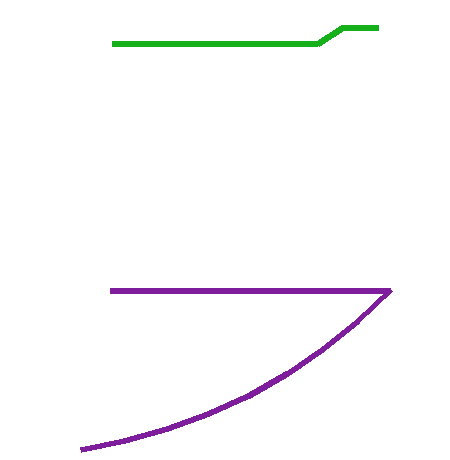

Ref stroke 7 vs Candidate Stroke 6 - error: 347.26729421522447


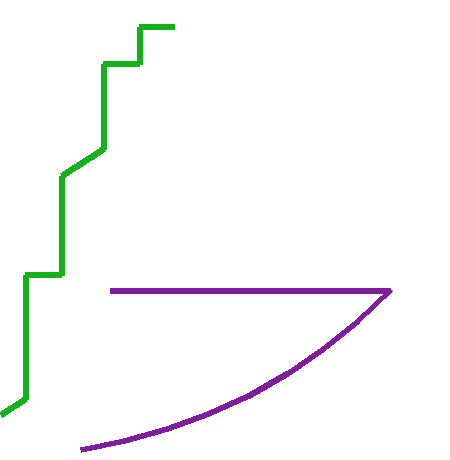

Ref stroke 7 vs Candidate Stroke 7 - error: 67.66489170708842


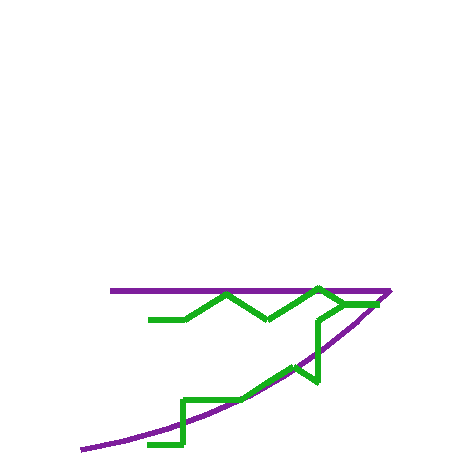

Ref stroke 7 vs Candidate Stroke 8 - error: 370.1351104664349


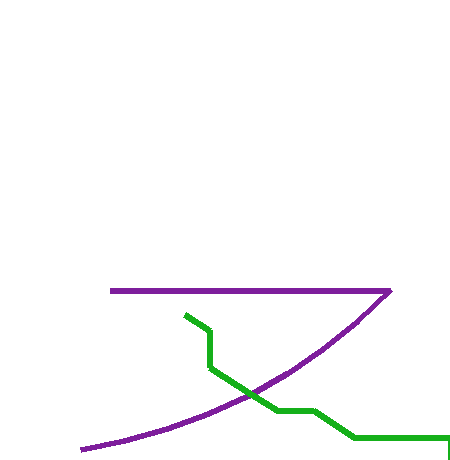

Ref stroke 8 vs Candidate Stroke 0 - error: 291.5596803712444


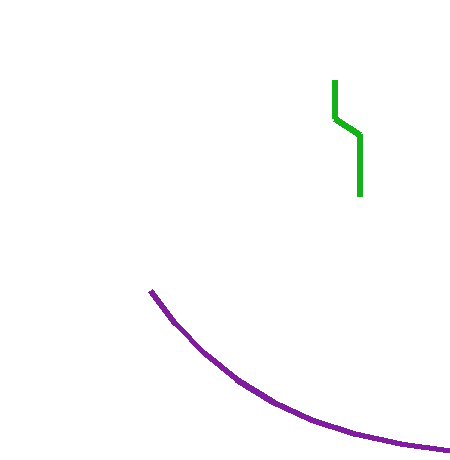

Ref stroke 8 vs Candidate Stroke 1 - error: 259.54530561967795


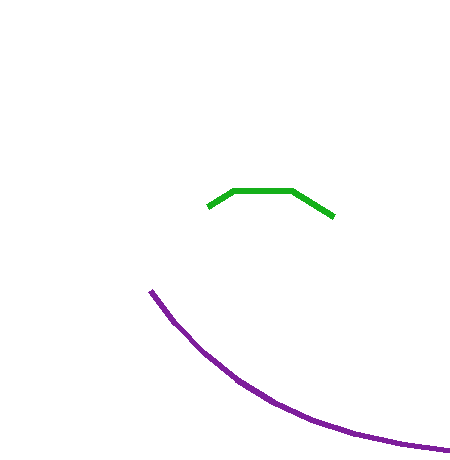

Ref stroke 8 vs Candidate Stroke 2 - error: 351.4556372748267


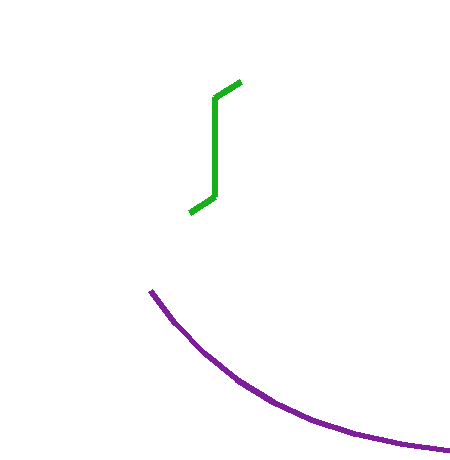

Ref stroke 8 vs Candidate Stroke 3 - error: 350.2230703169139


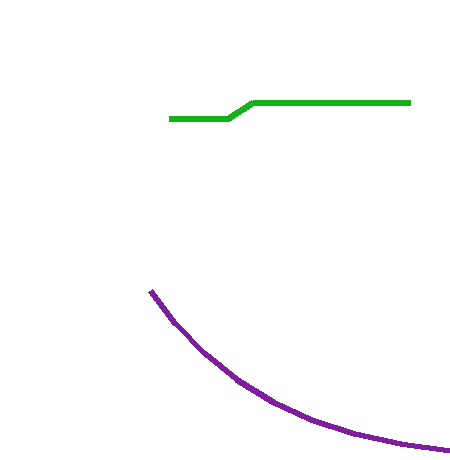

Ref stroke 8 vs Candidate Stroke 4 - error: 432.0559474116124


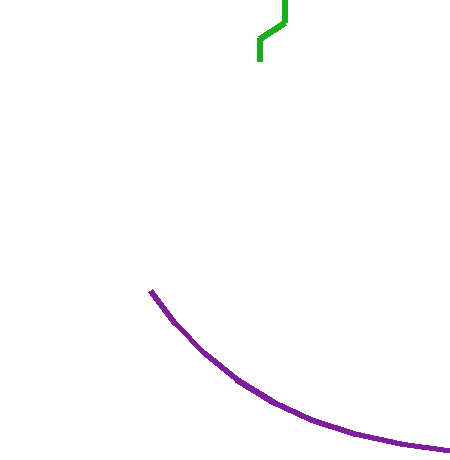

Ref stroke 8 vs Candidate Stroke 5 - error: 427.8577350334203


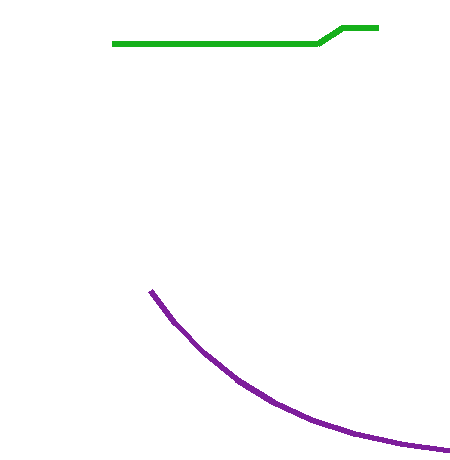

Ref stroke 8 vs Candidate Stroke 6 - error: 451.3153047707837


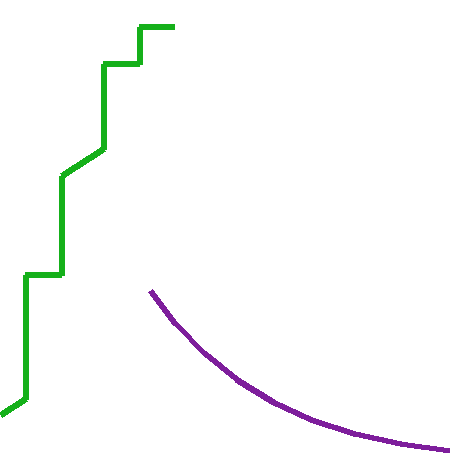

Ref stroke 8 vs Candidate Stroke 7 - error: 302.60039454157095


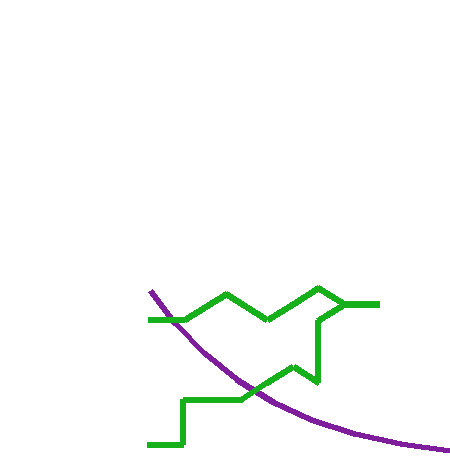

Ref stroke 8 vs Candidate Stroke 8 - error: 51.591298732856814


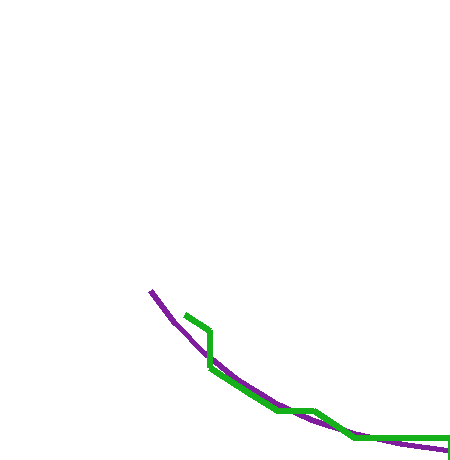

[[182 211 173 168  36 138 442 407 456]
 [285 222 215 137 210  74 368 409 410]
 [448 330 312 381 475 430 126 339 450]
 [251 135 207  82 208 127 299 343 320]
 [181 154  64 230 177 211 265 252 361]
 [ 34 132 149 171 177 234 392 295 277]
 [181  34 151 137 226 195 270 226 264]
 [377 274 261 354 428 406 347  67 370]
 [291 259 351 350 432 427 451 302  51]]
[377 274 261 354 428 406 347  67 370] - minimizing for priority stroke 7
Resulting error map:
[[  182   211   173   168    36   138   442 10000   456]
 [  285   222   215   137   210    74   368 10000   410]
 [  448   330   312   381   475   430   126 10000   450]
 [  251   135   207    82   208   127   299 10000   320]
 [  181   154    64   230   177   211   265 10000   361]
 [   34   132   149   171   177   234   392 10000   277]
 [  181    34   151   137   226   195   270 10000   264]
 [  377   274   261   354   428   406   347 10000   370]
 [  291   259   351   350   432   427   451 10000    51]]
[-1 -1 -1 -1 -1 -1 -1  7 -1]
[  448   33

In [5]:
alignments = alignStrokes(g, ref_g, l, ref_l)
print(alignments)

[5 6 4 3 0 1 2 7 8]


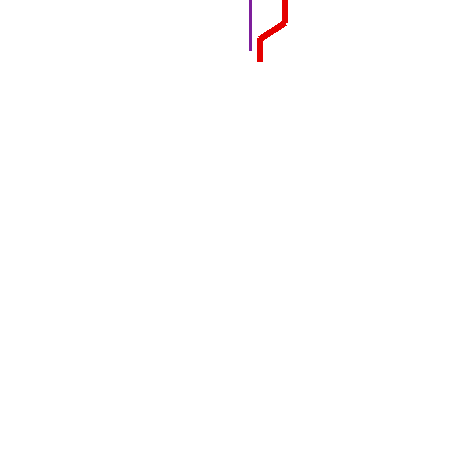

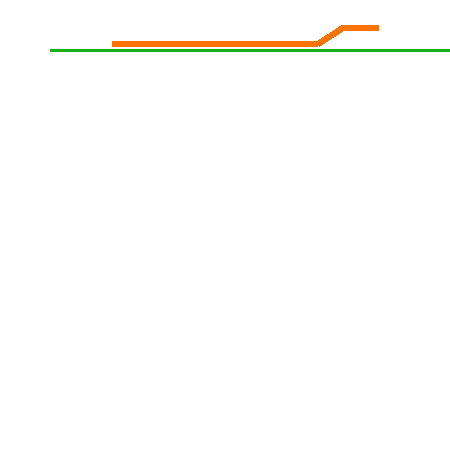

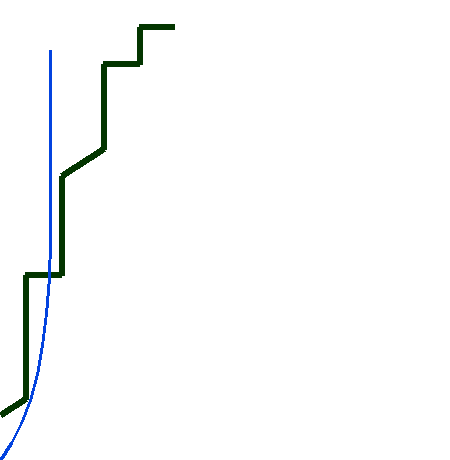

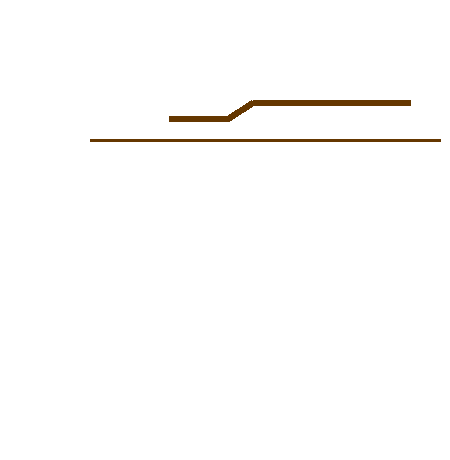

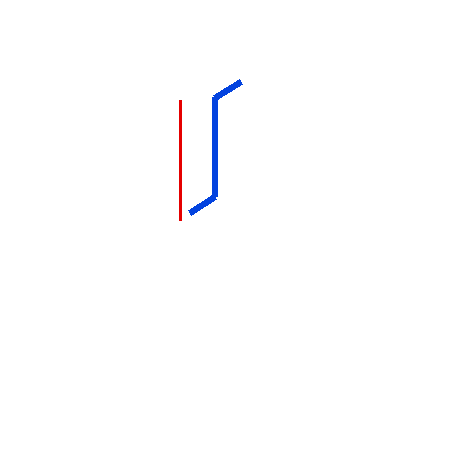

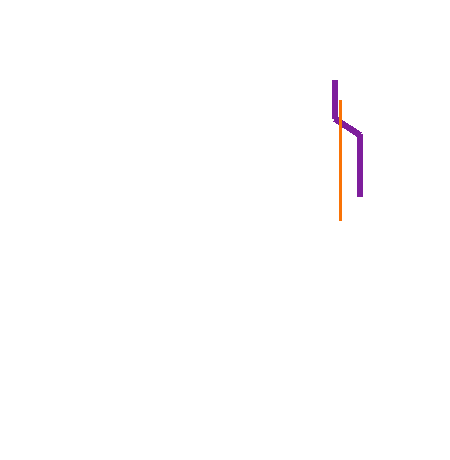

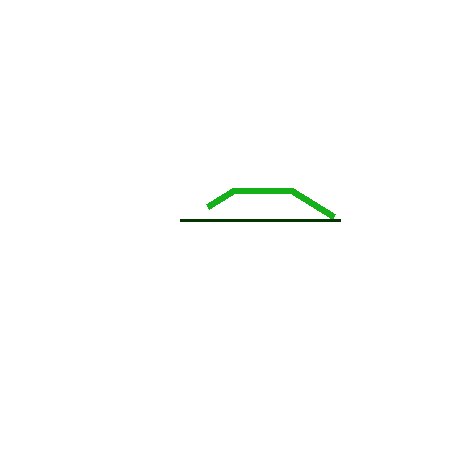

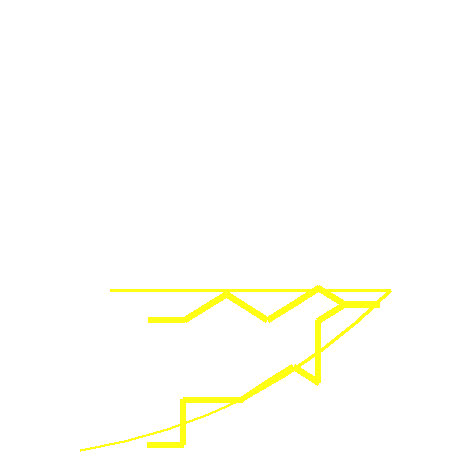

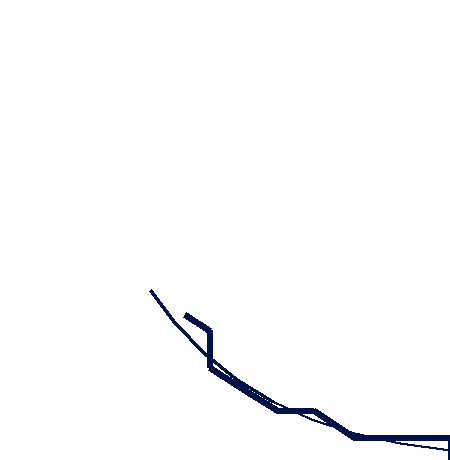

[5 6 4 3 0 1 2 7 8]


In [6]:
imgs = [Image.new(mode="RGBA", size=output_size) for _ in range(len(ref_g))]
img_full = Image.new(mode="RGBA", size=output_size)
seed(ref_l[0][0])
xcolors = ["#7e1e9c", "#15b01a", "#0343df", "#653700", "#e50000", "#f97306", "#033500", "#ffff14", "#001146"]
color_selection = [(int(c[1:3], 16), int(c[3:5], 16), int(c[5:7], 16)) for c in xcolors]
colors = color_selection[:len(ref_l)+1]
#colors = [(randint(0, 256), randint(0, 256), randint(0, 256)) for _ in range(len(ref_l)+1)]
colors_t = [(c[0], c[1], c[2], 70) for c in colors]

priority = [7, 2, 1, 8, 3, 6, 5, 4, 0]
#alignments = [7, 6, 5, 8, 3, 1, 0, 2, 4]
#alignments = [7 4 6 8 3 2 1 0 5]
#alignments = alignments[priority]

print(alignments)
for x in range(len(alignments)):
    i = np.where(alignments == x)[0][0]
    draw = ImageDraw.Draw(imgs[x])
    draw_full = ImageDraw.Draw(img_full)
    for a in range(len(g[i])-1):
        x1, y1 = g[i][a]
        x2, y2 = g[i][a+1]
        y1 = -(y1-output_size[1]/2)+output_size[1]/2
        y2 = -(y2-output_size[1]/2)+output_size[1]/2
        draw.line(((x1, y1), (x2, y2)), width=6, fill=colors[i])
        draw_full.line(((x1, y1), (x2, y2)), width=6, fill=colors[i])

for i in range(len(alignments)):
    draw = ImageDraw.Draw(imgs[i])
    draw_full = ImageDraw.Draw(img_full)
    for a in range(len(ref_g[i])-1):
        x1, y1 = ref_g[i][a]
        x2, y2 = ref_g[i][a+1]
        y1 = -(y1-output_size[1]/2)+output_size[1]/2
        y2 = -(y2-output_size[1]/2)+output_size[1]/2
        draw.line(((x1, y1), (x2, y2)), width=3, fill=colors[i])
        draw_full.line(((x1, y1), (x2, y2)), width=3, fill=colors[i])
        
#display(img_full)
for p in range(len(priority)):
    display(imgs[p])
    
print(alignments)